In [4]:
import pandas as pd
import dotenv

In [10]:
import os

dotenv.load_dotenv()

BASE_PATH = os.getenv('BASE_PATH')

TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'data', 'train.csv')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'data', 'val.csv')

In [11]:
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_val = pd.read_csv(TEST_DATA_PATH)

df_train

path  target
0    D:\audio_cls_coursework\data\train\casual_001.wav       3
1    D:\audio_cls_coursework\data\train\casual_002.wav       3
2    D:\audio_cls_coursework\data\train\casual_003.wav       3
3    D:\audio_cls_coursework\data\train\casual_004.wav       3
4    D:\audio_cls_coursework\data\train\casual_005.wav       3
..                                                 ...     ...
475   D:\audio_cls_coursework\data\train\siren_098.wav       0
476   D:\audio_cls_coursework\data\train\siren_100.wav       0
477   D:\audio_cls_coursework\data\train\siren_101.wav       0
478   D:\audio_cls_coursework\data\train\siren_103.wav       0
479   D:\audio_cls_coursework\data\train\siren_104.wav       0

[480 rows x 2 columns]

In [13]:
print(f'shape of training data = {df_train.shape}\n'
      f'shape of testing data  = {df_val.shape}')

shape of training data = (480, 2)
shape of testing data  = (105, 2)


In [17]:
print(f"duplicates in train.csv = {df_train.duplicated().sum()}\n"
      f"duplicates in val.csv   = {df_val.duplicated().sum()}")

duplicates in train.csv = 0
duplicates in val.csv   = 0


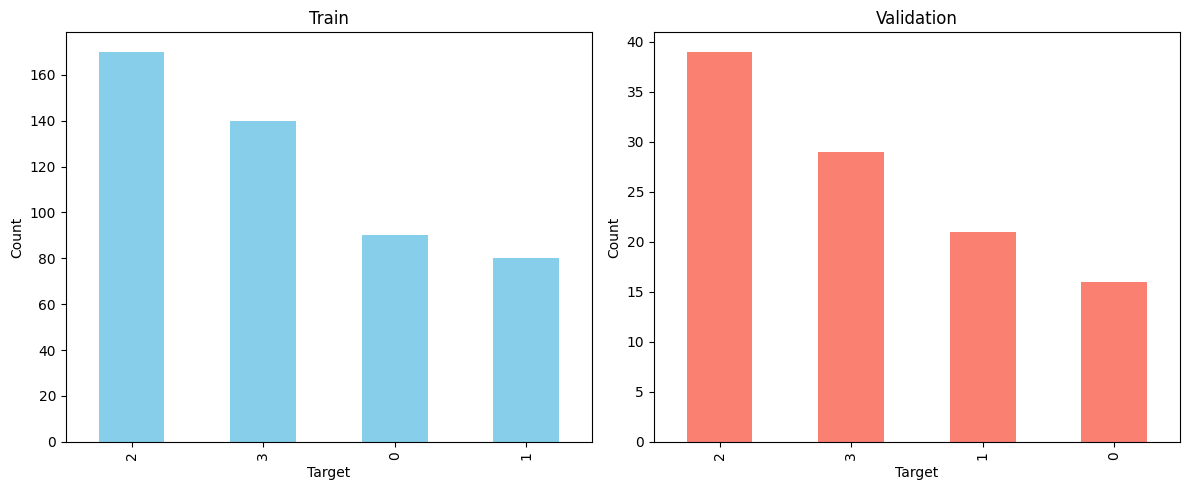

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 рядок, 2 колонки

# Train
df_train['target'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Train")
axes[0].set_xlabel("Target")
axes[0].set_ylabel("Count")

# Validation
df_val['target'].value_counts().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("Validation")
axes[1].set_xlabel("Target")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [27]:
import torchaudio


def get_audio_metadata(file_path: str):
    metadata = torchaudio.info(file_path)

    sample_rate = metadata.sample_rate
    num_channels = metadata.num_channels
    num_frames = metadata.num_frames
    duration = num_frames / sample_rate if sample_rate else None

    # Additional metadata (if available)
    bit_depth = getattr(metadata, "bits_per_sample", None)  # Only available for certain formats
    encoding = getattr(metadata, "encoding", None)  # Available for some formats

    return {
        "sample_rate": sample_rate,
        "duration": duration,
        "num_channels": num_channels,
        "bit_depth": bit_depth,
        "encoding": encoding,
    }

In [28]:
filepath_meta = pd.DataFrame(df_train["path"].apply(get_audio_metadata).to_list())

filepath_meta

sample_rate   duration  num_channels  bit_depth encoding
0          16000   4.063500             1          8    PCM_U
1          16000   5.107000             1          8    PCM_U
2          16000   5.822750             1          8    PCM_U
3          16000   3.443313             1          8    PCM_U
4          16000   2.863000             1          8    PCM_U
..           ...        ...           ...        ...      ...
475        16000  17.844562             1          8    PCM_U
476        16000  17.166438             1          8    PCM_U
477        16000   9.357000             1          8    PCM_U
478        16000   8.340625             1          8    PCM_U
479        16000   5.469437             1          8    PCM_U

[480 rows x 5 columns]

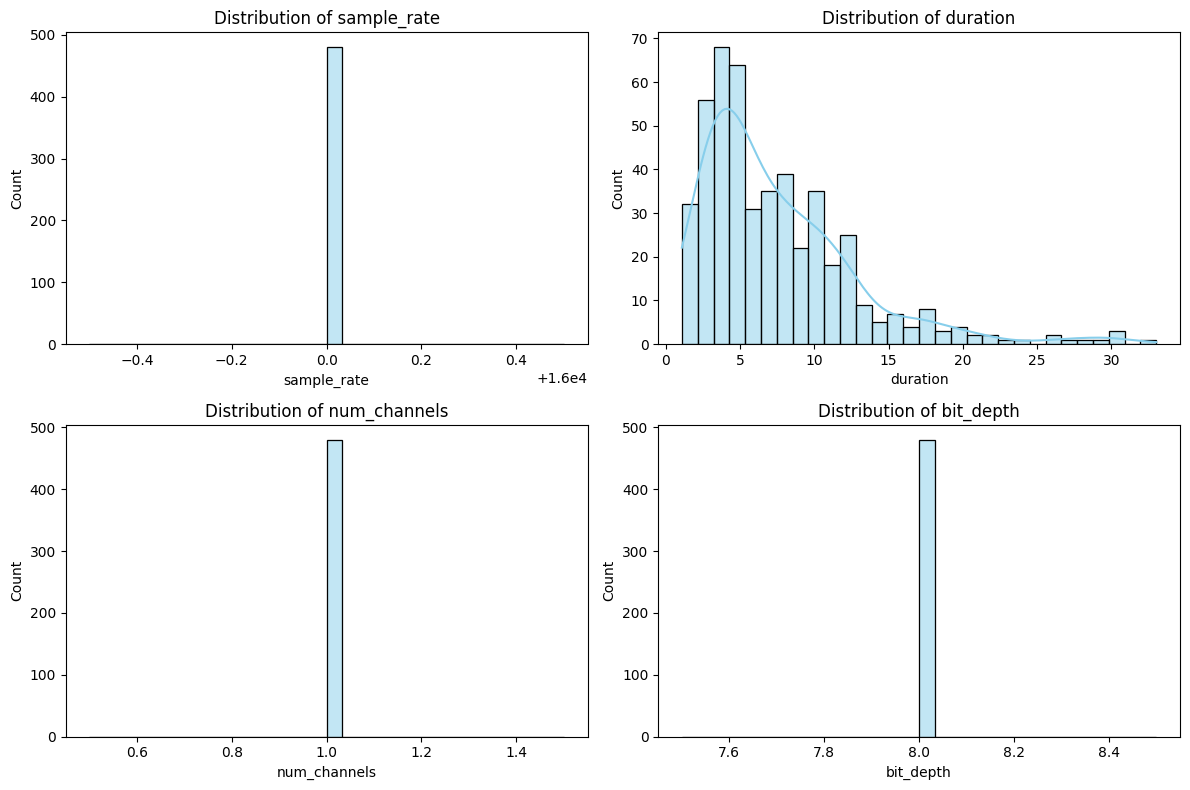

In [50]:
import seaborn as sns

cols = filepath_meta.columns[:4]

plt.figure(figsize=(12, 8))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(filepath_meta[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [29]:
def enrich_df_with_audiometa(input_df):
    return pd.concat([
        input_df,
        pd.DataFrame(input_df["path"].apply(get_audio_metadata).to_list())
    ], axis=1)

df_train = enrich_df_with_audiometa(df_train)
df_val   = enrich_df_with_audiometa(df_val)

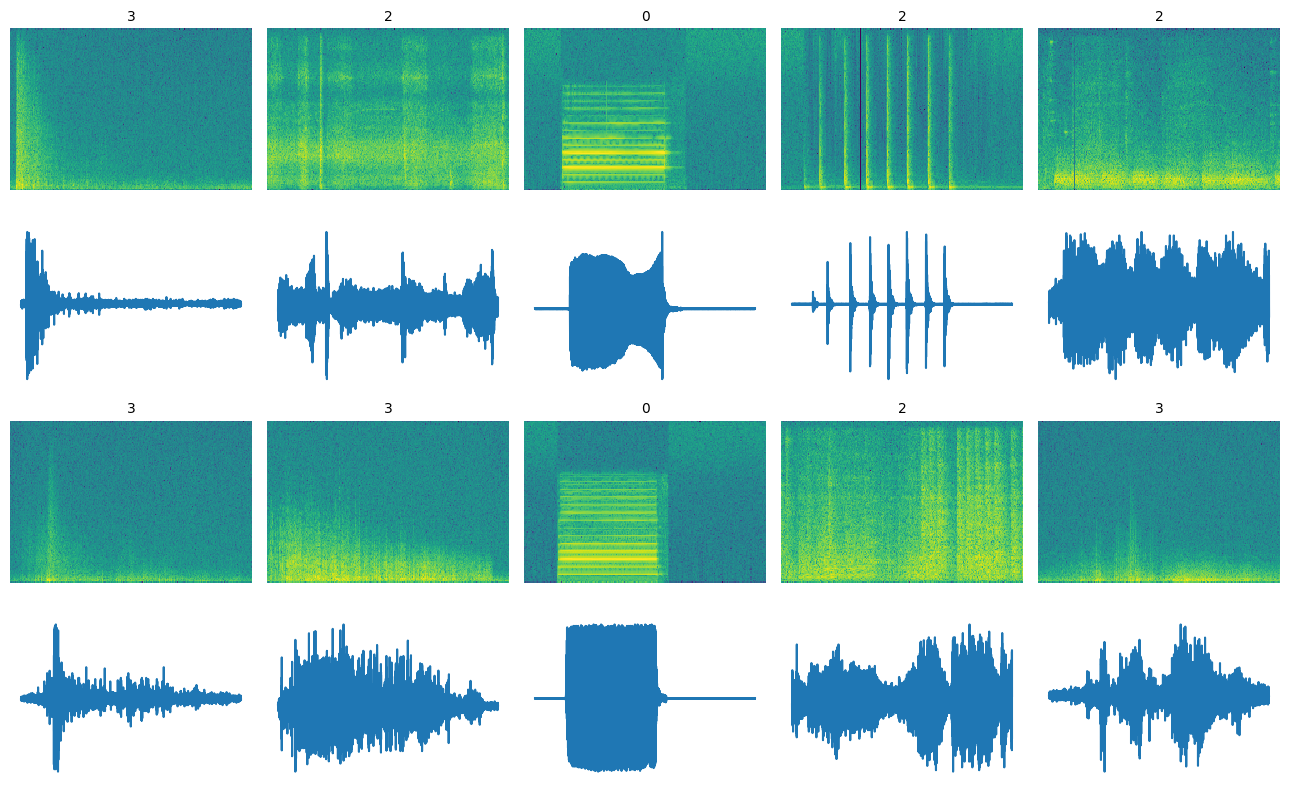

Playing: 3


Playing: 2


Playing: 0


Playing: 2


Playing: 2


Playing: 3


Playing: 3


Playing: 0


Playing: 2


Playing: 3


In [33]:
from scipy import signal
import numpy as np
import math
import IPython.display as ipd

# Original code from https://www.kaggle.com/code/mmoreaux/esc50-visualization and modified with Chat GPT

def plot_audio_spectrograms(file_paths, class_names):
    """
    Plots the spectrograms and waveforms of given audio files using their native sample rates.

    Args:
        file_paths (list of str): List of paths to audio files.
        class_names (list of str): List of corresponding class names.
    """
    num_files = len(file_paths)
    num_cols = 5  # Number of columns
    num_rows = math.ceil(num_files / num_cols) * 2  # Each audio takes 2 rows (spectrogram + waveform)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(13, num_rows * 2))

    if num_rows == 2:
        axs = np.reshape(axs, (num_rows, num_cols))  # Ensure correct indexing for small cases

    for idx, file_path in enumerate(file_paths):
        try:
            # Load audio with native sample rate
            waveform, sample_rate = torchaudio.load(file_path)
            waveform = waveform.numpy().T  # Convert to NumPy and transpose for compatibility

            # Compute spectrogram
            sampleFreqs, segmentTimes, sxx = signal.spectrogram(waveform[:, 0], sample_rate)

            # Determine row and column indices
            i, j = (idx // num_cols) * 2, idx % num_cols  # Spectrogram in row i, waveform in i+1

            # Plot spectrogram
            axs[i][j].pcolormesh((len(segmentTimes) * segmentTimes / segmentTimes[-1]),
                                 sampleFreqs,
                                 10 * np.log10(sxx + 1e-15))
            axs[i][j].set_title(f"{class_names[idx]}", fontsize=10)
            axs[i][j].set_axis_off()

            # Plot waveform
            axs[i + 1][j].plot(waveform)
            axs[i + 1][j].set_axis_off()

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    plt.tight_layout()
    plt.show()

    # Play audio
    for idx, file_path in enumerate(file_paths):
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            waveform = waveform.numpy().T
            print(f"Playing: {class_names[idx]}")
            ipd.display(ipd.Audio(waveform[:, 0], rate=sample_rate))
        except Exception as e:
            print(f"Error playing {file_path}: {e}")

sample_idxs = np.random.randint(0, min(len(df_train), len(df_val)), size=10)
plot_audio_spectrograms(
    df_train["path"].iloc[sample_idxs].to_list(),
    df_val["target"].iloc[sample_idxs].to_list()
)

In [43]:
import torch


class AudioDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        input_df,
        filenpath_col="filepath",
        target_col="target",
        sample_rate=16000,
        normalize_audio=True,
        audio_transforms=None,
    ):
        self.df = input_df.reset_index(drop=True)
        self.filepath_col = filenpath_col
        self.target_col = target_col
        self.sample_rate = sample_rate
        self.normalize_audio = normalize_audio
        self.audio_transforms = audio_transforms

    def __len__(self):
        return len(self.df)

    def _prepare_sample(self, idx):
        file_path = self.df[self.filepath_col].iloc[idx]
        au, sr = torchaudio.load(file_path)
        au = au[0]
        target_len = self.sample_rate * 5
        if len(au) < target_len:
            au = np.pad(au, (0, target_len - len(au)))
        else:
            au = au[:target_len]
        return au, self.df[self.target_col].iloc[idx]

    def __getitem__(self, idx: int):
        return self._prepare_sample(idx)

In [44]:
from audiomentations import Compose
from audiomentations import AddGaussianNoise, TimeStretch

testing_dataset = AudioDataset(
    input_df=df_train,
    filenpath_col="path",
    target_col="target",
    sample_rate=32000
)
testing_dataset_with_augs = AudioDataset(
    input_df=df_train,
    filenpath_col="path",
    target_col="target",
    sample_rate=32000,
    audio_transforms=Compose([
        AddGaussianNoise(min_amplitude=0.005, max_amplitude=0.01, p=0.5),
        TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    ])
)

In [45]:
check_idx = np.random.randint(len(testing_dataset))

au, cls_id = testing_dataset[check_idx]
au_aug, _ = testing_dataset_with_augs[check_idx]

In [46]:
def plot_wave_spectrograms(waveforms, sample_rate, class_names, num_cols=2, specs=None):
    """
    Plots the spectrograms and waveforms of given audio waveforms using a shared sample rate.

    Args:
        waveforms (list of np.ndarray): List of audio waveforms (NumPy arrays of shape [samples, channels]).
        sample_rate (int): Common sample rate for all waveforms.
        class_names (list of str): List of corresponding class names.
        num_cols (int): Number of columns in the plot layout. Default is 2.
        specs (list of np.ndarray, optional): List of precomputed spectrograms (2D tensors, only `sxx` values).
                                              If None, spectrograms will be computed automatically.
    """
    num_files = len(waveforms)
    num_rows = math.ceil(num_files / num_cols) * 2  # Each audio takes 2 rows (spectrogram + waveform)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.6, num_rows * 2))

    if num_rows == 2:
        axs = np.reshape(axs, (num_rows, num_cols))  # Ensure correct indexing for small cases

    for idx, (waveform, class_name) in enumerate(zip(waveforms, class_names)):

        # Determine row and column indices
        i, j = (idx // num_cols) * 2, idx % num_cols  # Spectrogram in row i, waveform in i+1

        # Compute spectrogram if not provided
        if specs is None:
            sampleFreqs, segmentTimes, sxx = signal.spectrogram(waveform, sample_rate)

            # Plot spectrogram
            axs[i][j].pcolormesh(segmentTimes, sampleFreqs, 10 * np.log10(sxx + 1e-15))
            axs[i][j].set_title(f"{class_name}", fontsize=10)
            axs[i][j].set_axis_off()
        else:
            # Plot spectrogram
            axs[i][j].imshow(specs[idx])
            axs[i][j].set_title(f"{class_name}", fontsize=10)
            axs[i][j].set_axis_off()

        # Plot waveform
        axs[i + 1][j].plot(waveform)
        axs[i + 1][j].set_axis_off()

    plt.tight_layout()
    plt.show()

    # Play audio
    for waveform, class_name in zip(waveforms, class_names):
        print(f"Playing: {class_name}")
        ipd.display(ipd.Audio(waveform, rate=sample_rate))

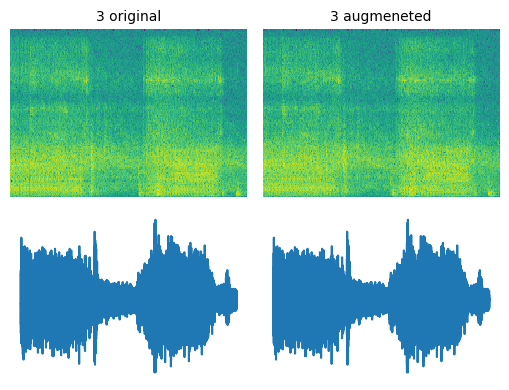

Playing: 3 original


Playing: 3 augmeneted


In [49]:
plot_wave_spectrograms(
    [au.numpy(), au_aug.numpy()],
    16000,
    [str(cls_id) + " original", str(cls_id) + " augmeneted"]
)